A simple 2-node simulation demonstration the application of GP-CaKe. Of particular interest are the covariance parameters
that define the constraints on the posterior shape of the causal kernels.

References:
    Ambrogioni, L., Hinne, M., van Gerven, M., & Maris, E. (2017). GP CaKe: Effective brain connectivity with causal kernels,
    pp. 1–10. Retrieved from http://arxiv.org/abs/1705.05603

Last updated on July 6th, 2017.

In [1]:
import numpy as np
import networkx as nx
import copy

"""
Simulation and GP-CaKe packages.
"""

import simulator as sim
import gpcake
import utility

In [2]:
"""
Simulation parameters. Here, we construct a 2-node graph with one connection (with max. strength <connection_strength>).
We create a 4 second time series per node, with a sampling rate of 100 Hz.
"""

p                       = 3
adj_mat                 = np.zeros((p,p))

adj_mat[0,1]            = 1
adj_mat[2,0]            = 1
adj_mat[2,1]            = 1

connection_strength     = 1.0

time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
n                       = int(time_period / time_step)

simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

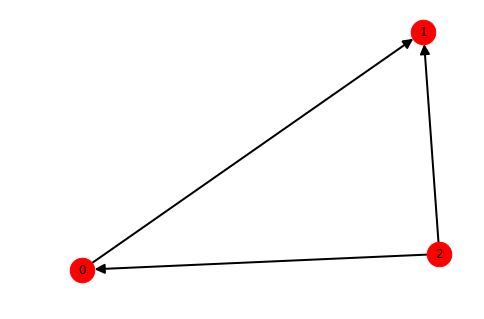

In [15]:
"""
The network.
"""

G = nx.DiGraph(np.array(adj_mat)) 
nx.draw(G, with_labels=True, width=2, node_size=600, arrowsize=20)

In [3]:
"""
Simulation settings. We generate <ntrials_train> trials to train the dynamic parameters on,
and <ntrials_test> to learn the GP posterior.
"""

ntrials_train                                       = 10
ntrials_test                                        = 10
simulation                                          = sim.integroDifferential_simulator()
print('Generating simulation samples')
(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, ntrials_test, simulation_params)

Generating simulation samples
connectivity_relaxations_constants:  [[0.         6.66666667 6.66666667]
 [6.66666667 0.         6.66666667]
 [6.66666667 6.66666667 0.        ]]


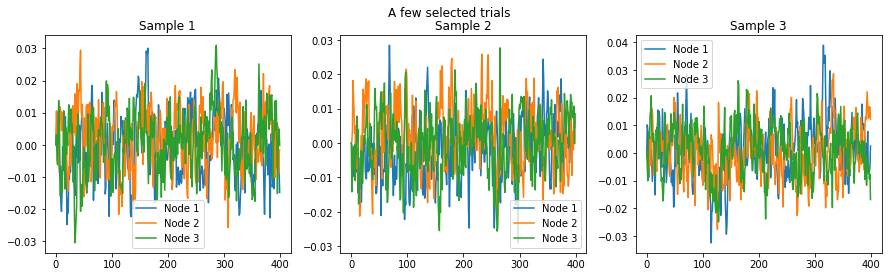

In [5]:
"""
Plot a few samples to see the generated time series.
"""

utility.plot_samples(training_samples[0:3])

In [6]:
"""
Simulation is done. Time to bake some cake!
"""

cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period)
cake.dynamic_parameters["number_sources"] = 3

"""
Select internal dynamics type. Currently implemented are "Relaxation" and "Oscillation".
"""

cake.dynamic_type = "Relaxation"

In [7]:
# """
# Only use a number of the simulated samples and add lagg
# """
# lagg = [1,2,-1]

# def add_lagg(samples, lagg):
#     for i, sample in enumerate(samples):
#         for j,l in enumerate(lagg):
#             sample[j] = np.roll(sample[j], l, axis=1)
#         temp[i] = sample
        
# """
# Ground Truth
# """
# temp = copy.deepcopy(ground_truth)
# # add_lagg(temp, lagg)
# lagged_ground_truth = temp
        
# """
# Training
# """
# temp = copy.deepcopy(training_samples)
# add_lagg(temp, lagg)
# temp = [np.delete(sample, 2, 0) for sample in temp]
# observed_training_samples = temp

# """
# Testing
# """
# temp = copy.deepcopy(testing_samples)
# add_lagg(temp, lagg)
# temp = [np.delete(sample, 2, 0) for sample in temp]
# observed_testing_samples = temp

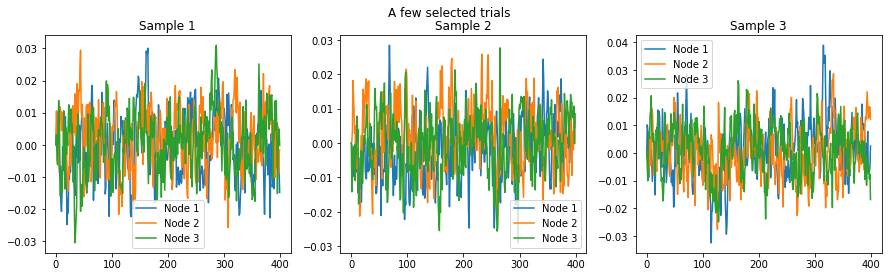

In [8]:
"""
Plot a few samples to see the generated time series.
"""

utility.plot_samples(training_samples[0:3])

In [9]:
"""
Optimize the univariate likelihoods for each node for the dynamic parameters using a grid search.
"""

dynamic_parameters_range = {
    'relaxation_constant' : {
        'step'  : 2,
        'min'   : 20,
        'max'   : 50
    },
    'amplitude' : {
        'step'  : 0.001,
        'min'   : 0.005,
        'max'   : 0.015
    }
}

print('Learning dynamic parameters')
cake.learn_dynamic_parameters(training_samples, dynamic_parameters_range)

Learning dynamic parameters


In [10]:
"""
Set the parameters of the causal kernel.
"""

cake.covariance_parameters = {  "time_scale"        : 0.15,     # Temporal smoothing
                                "time_shift"        : 0.05,     # Temporal offset
                                "causal"            : "yes",    # Hilbert transform
                                "spectral_smoothing": np.pi }   # Temporal localization
cake.noise_level = 0.05

In [11]:
"""
Compute the posteriors for each of the p*(p-1) connections.
"""

print('Computing posterior kernels')
connectivity = cake.run_analysis(testing_samples)

Computing posterior kernels


In [11]:
temp = reversed(ground_truth)

for t in temp:
    print(t)

[[0.0000000e+00 6.2433283e-05 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.2433283e-05 6.2433283e-05 0.0000000e+00]]
[[0.0000000e+00 6.6402014e-05 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [6.6402014e-05 6.6402014e-05 0.0000000e+00]]
[[0.00000000e+00 7.06212261e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.06212261e-05 7.06212261e-05 0.00000000e+00]]
[[0.00000000e+00 7.51065934e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.51065934e-05 7.51065934e-05 0.00000000e+00]]
[[0.00000000e+00 7.98747606e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.98747606e-05 7.98747606e-05 0.00000000e+00]]
[[0.00000000e+00 8.49434026e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.49434026e-05 8.49434026e-05 0.00000000e+00]]
[[0.0000000e+00 9.0331287e-05 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [9.0331287e-05 9.0331287e-05 0.0000000e+00]]
[[0.00000000

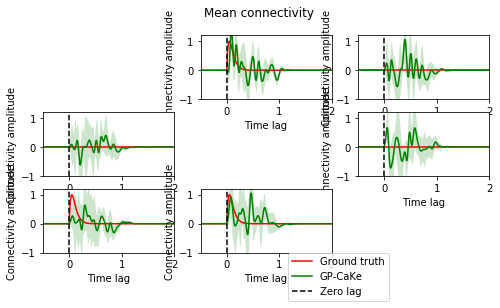

In [12]:
"""
Visualize the posterior kernels
"""
utility.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)